In [1]:
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import pandas as pd
import math
import datetime
import os
import pickle
import sys
import mlccd_models
%load_ext autoreload
%autoreload 2


2024-12-12 12:16:36.497146: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 12:16:36.503768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 12:16:36.512000: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 12:16:36.514262: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 12:16:36.520553: I tensorflow/core/platform/cpu_feature_guar

### Load CCDData and add classical variables to metadata

In [2]:
data_base_path = os.path.expanduser("~/data/CCD_data/")
data_tritium = mlccd_models.CCDData(os.path.join(data_base_path,"Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/diffused_H3_5000000.h5"),image_unit="keV")
clusters_tritium = mlccd_models.add_cluster_metadata(data_tritium)

In [3]:
data_gamma = mlccd_models.CCDData(os.path.join(data_base_path,"Simulated_training_clusters/2024-10-17-tritium-and-gamma-100keV-more-realistic-diffusion/diffused_gamma_70000000.h5"),image_unit="keV")
clusters_gamma = mlccd_models.add_cluster_metadata(data_gamma)


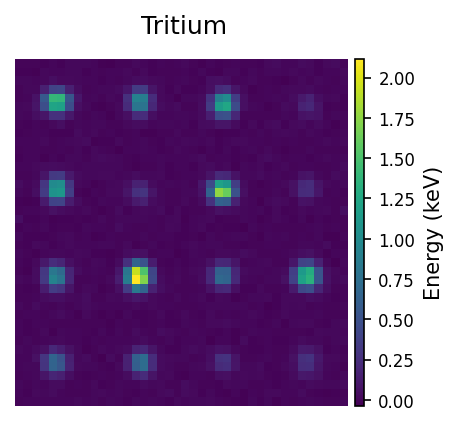

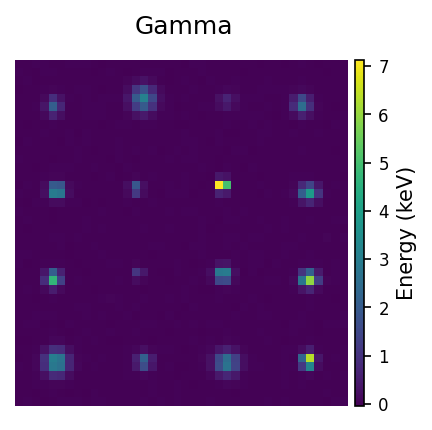

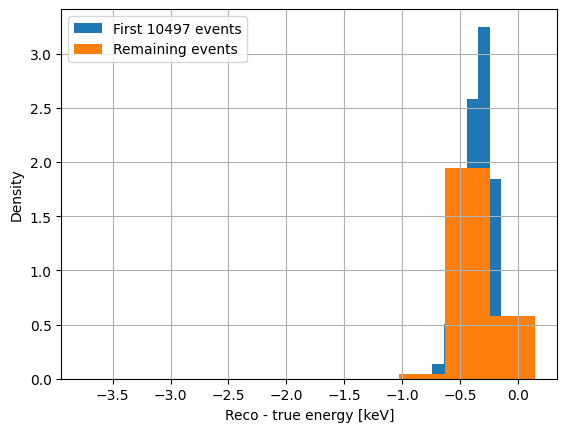

In [4]:
data_tritium.plot(title="Tritium")
data_gamma.plot(title="Gamma")
data_tritium.tracks_metadata["energyResidual"] = data_tritium.tracks_metadata["clusterEnergy"]-data_tritium.tracks_metadata["energyActiveCCDSumKeV"]
axs = data_tritium.tracks_metadata["energyResidual"].iloc[:10497].hist(label = "First 10497 events",density=True)
axs = data_tritium.tracks_metadata["energyResidual"].iloc[10497:].hist(label = "Remaining events",density=True)
axs.set_xlabel("Reco - true energy [keV]")
axs.set_ylabel("Density")
axs.legend()

### Perform baseline selection

In [5]:
baseline_query = "clusterEnergy < 20 and clusterEnergy>0.2 and clusterMinSigma > 0.4  and clusterMinSigma < 2"
baseline_gamma = data_gamma.tracks_metadata.query(baseline_query)
baseline_tritium = data_tritium.tracks_metadata.query(baseline_query)
print("N_events baseline, tritium: ",len(baseline_tritium))
print("N_events baseline, gamma: ",len(baseline_gamma))

N_events baseline, tritium:  942185
N_events baseline, gamma:  1101393


### Make 2D histogram of energy and minSigma, normalized

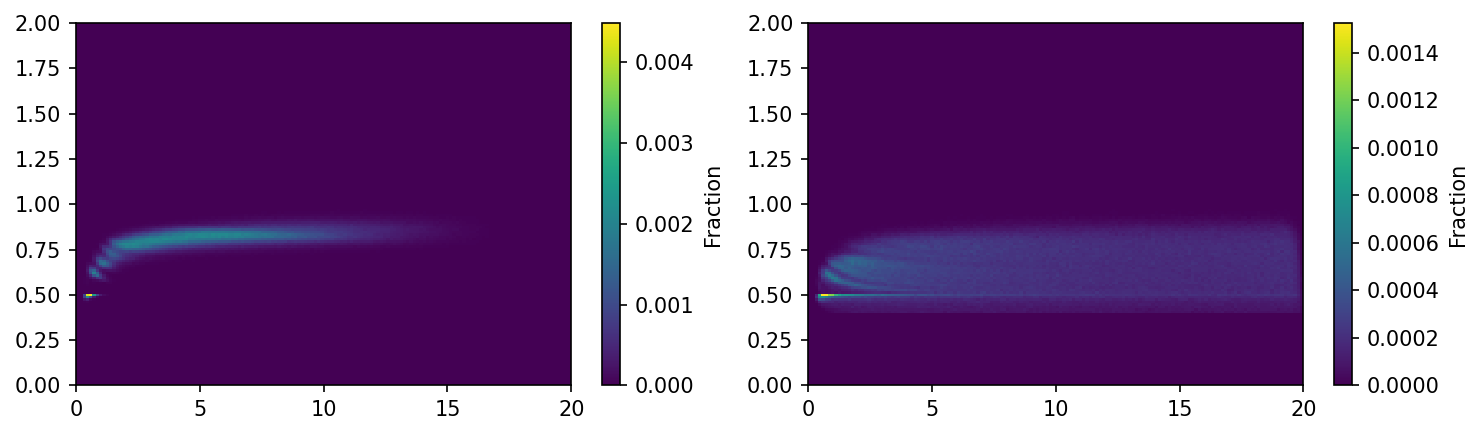

In [6]:
bins = [150,150]
### NB this range should extend to the full baseline selection range
arange =[0,20],[0,2]
h, xbins, ybins = np.histogram2d(baseline_tritium["clusterEnergy"].to_numpy(), baseline_tritium["clusterMinSigma"].to_numpy(),bins=bins,range=arange)
X, Y =  np.meshgrid(xbins, ybins)
h_integral = sum(sum(h))
h= h/h_integral

h_gamma, xbins_gamma, ybins_gamma = np.histogram2d(baseline_gamma["clusterEnergy"].to_numpy(), baseline_gamma["clusterMinSigma"].to_numpy(),bins=bins,range=arange)
X_gamma, Y_gamma =  np.meshgrid(xbins_gamma, ybins_gamma)
h_gamma_integral = sum(sum(h_gamma))
h_gamma= h_gamma/h_gamma_integral

fig13, axs13 = plt.subplots(1,2,figsize=(10,3), dpi=150,tight_layout = True)
pcm0 = axs13[0].pcolormesh(X, Y, h.transpose())
fig13.colorbar(pcm0, ax=axs13[0], label="Fraction")
pcm1 = axs13[1].pcolormesh(X_gamma, Y_gamma, h_gamma.transpose())
fig13.colorbar(pcm1, ax=axs13[1], label="Fraction")


### Plot histogram of bin values from 2D map

Text(0.5, 0, 'Fraction of tritium in bin')

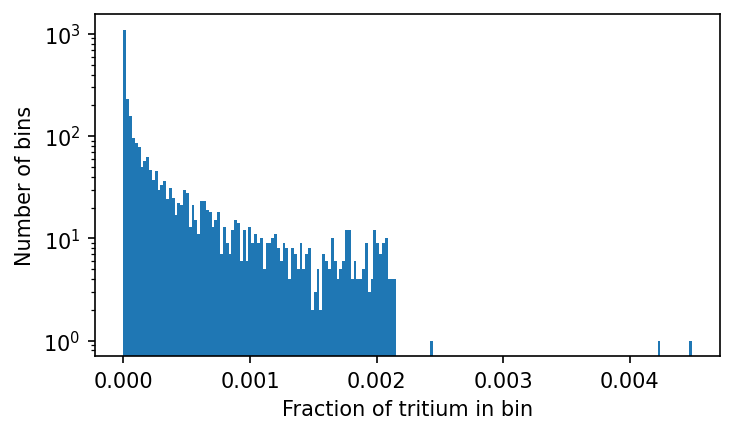

In [7]:
bin_value_array = h.flatten()
bin_value_array = bin_value_array[bin_value_array!=0]

fig14, axs14 = plt.subplots(1,1,figsize=(5,3), dpi=150,tight_layout = True)
bin_values = plt.hist(bin_value_array,bins=200)
axs14.set_yscale("log")
axs14.set_ylabel('Number of bins')
axs14.set_xlabel('Fraction of tritium in bin')


### Count fraction of tritium collected as we start from the best bins and add increasingly weaker bins

Text(0.5, 0, 'Signal fraction threshold')

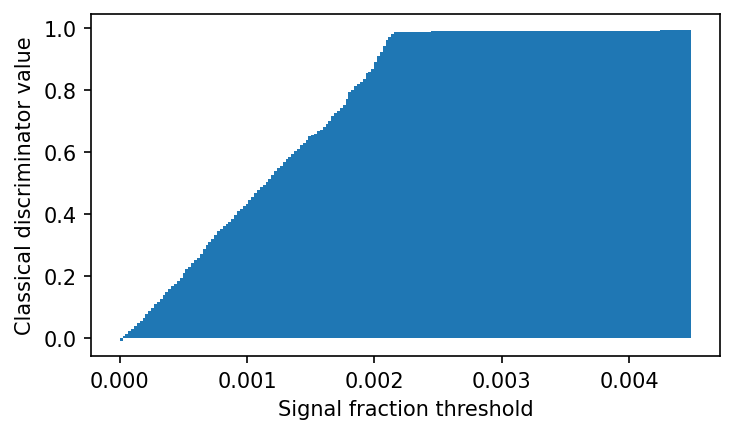

In [8]:
### cumulative[i] represents how much of the tritium is contained in bins at least as good as bin i
cumulative = np.zeros(len(bin_values[0]))
for i in range(len(bin_values[0])-1,-1,-1):
    for j in range(i,len(bin_values[0])):
        cumulative[i] += bin_values[0][j] *0.5* (bin_values[1][j]+bin_values[1][j+1])

### take 1 - cumulative integral as discriminator value, so that larger = more pure
fig15, axs15 = plt.subplots(1,1,figsize=(5,3), dpi=150,tight_layout = True)
plt.bar(bin_values[1][:len(cumulative)],1-cumulative,width=(bin_values[1][2]-bin_values[1][1]),align='edge')
axs15.set_ylabel('Classical discriminator value')
axs15.set_xlabel('Signal fraction threshold')# axs15.set_yscale("log")

### Calculate discriminator values for each cluster

In [9]:
tritium_classical_discriminator_values = [] 
# Convert the DataFrame to NumPy arrays for faster access
energy_array = data_tritium.tracks_metadata['clusterEnergy'].to_numpy()
sigma_array = data_tritium.tracks_metadata['clusterMinSigma'].to_numpy()

# Precompute the valid indices based on the baseline query
valid_indices = data_tritium.tracks_metadata.query(baseline_query).index

for i in range(len(data_tritium.tracks_metadata)):
    this_disc_value = 0
    # Check if the current index is valid
    if i in valid_indices:
        this_bin_x = np.searchsorted(xbins, energy_array[i]) - 1
        this_bin_y = np.searchsorted(ybins, sigma_array[i]) - 1
        this_bin_fraction = h[this_bin_x][this_bin_y] if this_bin_x >= 0 and this_bin_y >= 0 else 0
        
        if this_bin_fraction > 0:
            this_fraction_position = np.searchsorted(bin_values[1], this_bin_fraction) - 1
            if this_fraction_position > 0:
                this_disc_value = 1 - cumulative[this_fraction_position]

    tritium_classical_discriminator_values.append(this_disc_value)

In [10]:
gamma_classical_discriminator_values = [] 
# Convert the DataFrame to NumPy arrays for faster access
energy_array = data_gamma.tracks_metadata['clusterEnergy'].to_numpy()
sigma_array = data_gamma.tracks_metadata['clusterMinSigma'].to_numpy()

# Precompute the valid indices based on the baseline query
valid_indices = data_gamma.tracks_metadata.query(baseline_query).index

for i in range(len(data_gamma.tracks_metadata)):
    this_disc_value = 0
    # Check if the current index is valid
    if i in valid_indices:
        this_bin_x = np.searchsorted(xbins, energy_array[i]) - 1
        this_bin_y = np.searchsorted(ybins, sigma_array[i]) - 1
        this_bin_fraction = h[this_bin_x][this_bin_y] if this_bin_x >= 0 and this_bin_y >= 0 else 0
        
        if this_bin_fraction > 0:
            this_fraction_position = np.searchsorted(bin_values[1], this_bin_fraction) - 1
            if this_fraction_position > 0:
                this_disc_value = 1 - cumulative[this_fraction_position]

    gamma_classical_discriminator_values.append(this_disc_value)

Text(0.5, 0, 'Discriminator score')

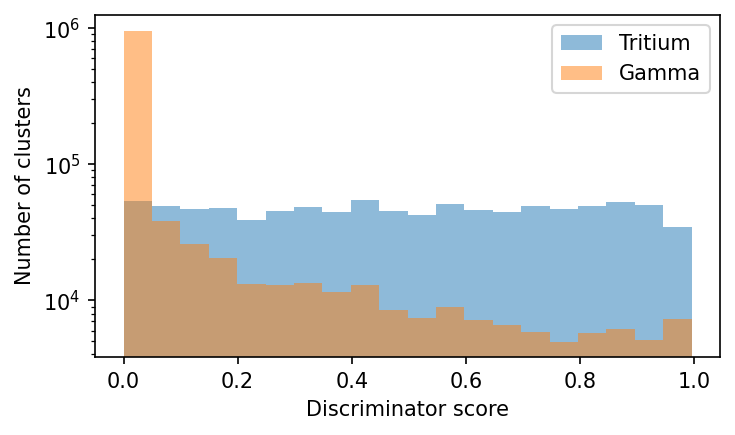

In [11]:
fig14, axs14 = plt.subplots(1,1,figsize=(5,3), dpi=150,tight_layout = True)
_ = plt.hist(tritium_classical_discriminator_values,bins=20, label="Tritium", alpha=0.5)
_ = plt.hist(gamma_classical_discriminator_values,bins=20, label="Gamma", alpha=0.5)
plt.legend()
axs14.set_yscale("log")
axs14.set_ylabel('Number of clusters')
axs14.set_xlabel('Discriminator score')

In [12]:
### Add disciminator values to dataframe
data_tritium.tracks_metadata["classicalDiscriminatorS"] = tritium_classical_discriminator_values
data_gamma.tracks_metadata["classicalDiscriminatorS"] = gamma_classical_discriminator_values

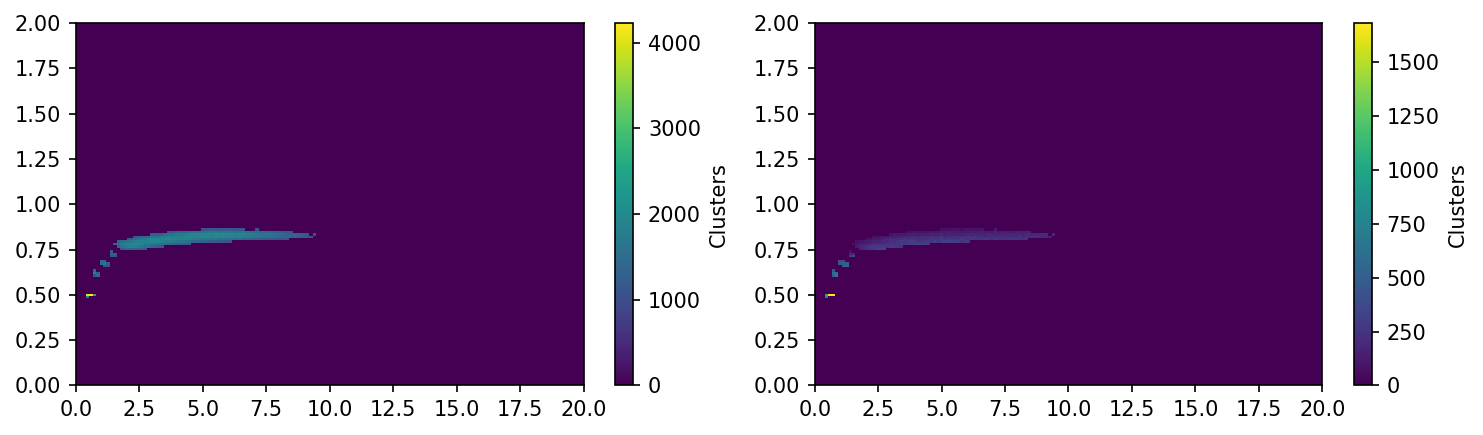

In [13]:
### Sanity check: plot map of where clusters fall as function of discriminator threshold
threshold=0.5
selected_tritium = data_tritium.tracks_metadata.query("classicalDiscriminatorS > {}".format(threshold))
selected_gamma = data_gamma.tracks_metadata.query("classicalDiscriminatorS > {}".format(threshold))
h_test_tritium, xbins_test_tritium, ybins_test_tritium = np.histogram2d(selected_tritium["clusterEnergy"].to_numpy(), selected_tritium["clusterMinSigma"].to_numpy(),bins=bins,range=arange)
h_test_gamma, xbins_test_gamma, ybins_test_gamma = np.histogram2d(selected_gamma["clusterEnergy"].to_numpy(), selected_gamma["clusterMinSigma"].to_numpy(),bins=bins,range=arange)

X_t, Y_t =  np.meshgrid(xbins_test_tritium, ybins_test_tritium)
X_g, Y_g =  np.meshgrid(xbins_test_gamma, ybins_test_gamma)
fig16, axs16 = plt.subplots(1,2,figsize=(10,3), dpi=150,tight_layout = True)
pcm0 = axs16[0].pcolormesh(X_t, Y_t, h_test_tritium.transpose())
fig16.colorbar(pcm0, ax=axs16[0], label="Clusters")
pcm1 = axs16[1].pcolormesh(X_g, Y_g, h_test_gamma.transpose())
fig16.colorbar(pcm1, ax=axs16[1], label="Clusters")

In [14]:
threshold=0.19
print("Baseline trit",len(data_tritium.tracks_metadata.query("{}".format(baseline_query))))
print("Classical disc:",len(data_tritium.tracks_metadata.query("classicalDiscriminatorS > {} and {}".format(threshold,baseline_query))))
print("TPR:",len(data_tritium.tracks_metadata.query("classicalDiscriminatorS > {} and {}".format(threshold,baseline_query)))/len(data_tritium.tracks_metadata.query("{}".format(baseline_query))))
print()
print("Baseline gamma",len(data_gamma.tracks_metadata.query("{}".format(baseline_query))))
print("Classical disc:",len(data_gamma.tracks_metadata.query("classicalDiscriminatorS > {} and {}".format(threshold,baseline_query))))
print("FPR:",len(data_gamma.tracks_metadata.query("classicalDiscriminatorS > {} and {}".format(threshold,baseline_query)))/len(data_gamma.tracks_metadata.query("{}".format(baseline_query))))



Baseline trit 942185
Classical disc: 757642
TPR: 0.8041329462897414

Baseline gamma 1101393
Classical disc: 142355
FPR: 0.12924995891566407


In [15]:
data_tritium.write("tritium_10_17_add_classical_disc.h5")
data_gamma.write("gamma_10_17_add_classical_disc.h5")

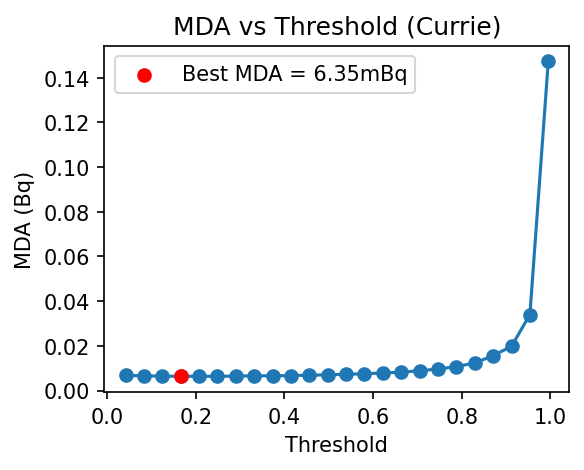

(0.006349870067398756, 0.16592045263580577)

In [22]:
gamma_scores = data_gamma.tracks_metadata['classicalDiscriminatorS']
gamma_labels = np.zeros((len(gamma_scores)))
tritium_scores = data_tritium.tracks_metadata['classicalDiscriminatorS']
tritium_labels = np.ones((len(tritium_scores)))
both_scores = np.concatenate((gamma_scores, tritium_scores))
both_labels = np.concatenate((gamma_labels, tritium_labels)).astype('int')
mlccd_models.scan_mda(both_labels, both_scores, plot=True, use_currie=True)